In [37]:
import torch
import torch.nn as nn
from data.graph_loader import GraphLoader, load_highschool
from torch_geometric.utils import to_networkx, from_networkx, to_undirected, subgraph
from torch_geometric.transforms import LargestConnectedComponents, AddRandomWalkPE
from rl.gnn import RGCN, MyModel
import networkx as nx
import scipy.sparse as sparse

# Data
device = torch.device("cuda")
# graph = GraphLoader(root='data/',graph_name="Cora")
# graph = graph()

# mask = graph.y==1
# graph.edge_index = subgraph(mask, graph.edge_index, relabel_nodes=True)[0]
# graph.x = graph.x[mask]
# graph.train_mask = graph.train_mask[mask]
# graph.val_mask = graph.val_mask[mask]
# graph.test_mask = graph.test_mask[mask]

# trans = LargestConnectedComponents()
# graph = trans(graph)
# random_walk_pe_cora = torch.load("random_walk_pe_cora.pt").to(device)

# nx_graph = to_networkx(graph)
# adj = nx.adjacency_matrix(nx_graph, dtype=float)
# eigenval, _ = sparse.linalg.eigsh(adj, k=1, which='LA')
# graph = graph.to(device)
# num_nodes = graph.x.shape[0]

from torch_geometric.data import Data
edge_index = load_highschool()
num_nodes = 70
node_idx = torch.arange(num_nodes).to(device)
edge_index = to_undirected(edge_index, num_nodes=num_nodes)
graph = Data(x=node_idx.cpu(), edge_index=edge_index)
nx_graph = to_networkx(graph)
adj = nx.adjacency_matrix(nx_graph, dtype=float)
eigenval, _ = sparse.linalg.eigsh(adj, k=1, which='LA')
graph = graph.to(device)

hidden_dim = 128
q_value = MyModel(num_nodes=num_nodes,
    hidden_dim=hidden_dim).to(device)
q_value.load_state_dict(torch.load("/scratch/yongjian/rl-node-immu/saved_models/q_model_degree_lr_0.005ns_16_del_4_o2_90.pth"))
q_value.eval()

state = torch.zeros(num_nodes, 1).long().to(device)

with torch.no_grad():
    for i in range(16):
        mask = (state == 0).squeeze()
        node_value = q_value(graph.x, graph.edge_index, state)
        selected_node = torch.argmax(node_value[mask]).item()
        index = mask.nonzero().squeeze()[selected_node]
        action = index
        state[action] = 1

nx_graph.remove_nodes_from(torch.where(state == 1)[0].cpu().numpy())
adj = nx.adjacency_matrix(nx_graph, dtype=float)
eigenval_after, _ = sparse.linalg.eigsh(adj, k=1, which='LA')

print(eigenval)
print(eigenval_after)


[9.92710445]
[6.68531685]


In [31]:
from torch_geometric.transforms import AddRandomWalkPE
trans = AddRandomWalkPE(64)
random_walk_pe = trans(graph).random_walk_pe
random_walk_pe = random_walk_pe.cpu()
torch.save(random_walk_pe, 'datasets/random_walk_pe_highschool_64.pt')

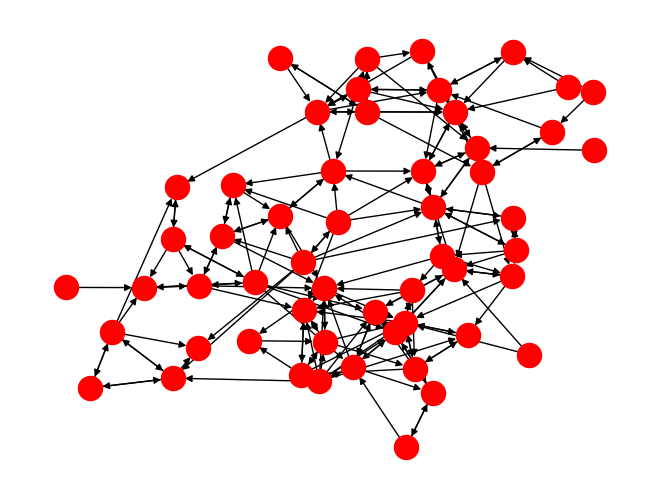

In [19]:
pos = nx.kamada_kawai_layout(nx_graph)  # Position nodes using Fruchterman-Reingold force-directed algorithm

nx.draw(nx_graph, pos, with_labels=False, node_size=300, node_color='red')

In [3]:
model = torch.load("/scratch/yongjian/rl-node-immu/saved_models/q_model_degree_lr_0.0001ns_16_del_4_o2_90.pth")

In [7]:
model['embeddings.weight'].shape

torch.Size([70, 64])

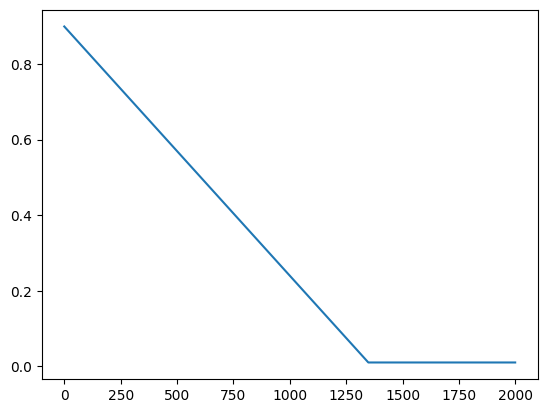

In [7]:
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 1 / 1500
epsilon = 0.9

a = []
for i in range(2000):
    epsilon = max(
                        min_epsilon, epsilon - (
                            max_epsilon - min_epsilon
                        ) * epsilon_decay
                    )
    a.append(epsilon)

import matplotlib.pyplot as plt
plt.plot(a)
plt.show()

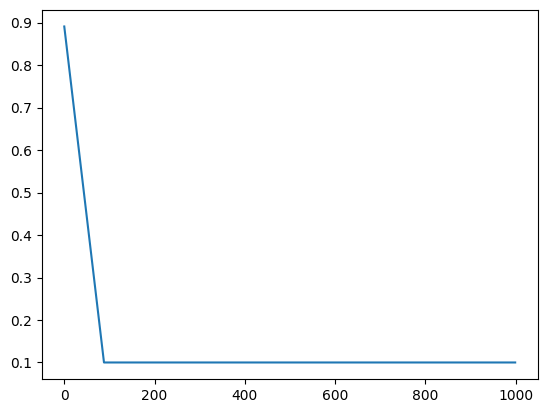

In [14]:
import torch
q_values = torch.rand(5)
ob = torch.tensor([0,0,1,1,0])
mask = (ob == 0).squeeze()

In [16]:
selected_node = torch.argmax(q_values[mask]).item()
index = mask.nonzero().squeeze()[selected_node]
action = index
action

tensor(4)

In [17]:
valid_q_values = q_values[ob != 1]
action = torch.argmax(valid_q_values).item()
action

2

In [18]:
q_values

tensor([0.2118, 0.0362, 0.3130, 0.6676, 0.7428])

In [13]:
action

1

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class EdgeDataset(Dataset):
    def __init__(self, edge_index, y):
        self.edge_index = edge_index
        self.y = y
        self.num_edges = edge_index.size(1)

    def __len__(self):
        return self.num_edges

    def __getitem__(self, idx):
        return self.edge_index[:, idx], self.y[idx]

import random
import copy
from torch.utils.data.sampler import Sampler

class EdgeBatchSampler(Sampler):
    def __init__(self, edge_index, batch_size):
        self.edge_index = edge_index
        self.batch_size = batch_size
        self.num_edges = edge_index.size(1)
        self.edge_list = list(range(self.num_edges))

    def __iter__(self):
        random.shuffle(self.edge_list)
        batch = []
        nodes_in_batch = set()
        edge_list = copy.deepcopy(self.edge_list)

        while len(edge_list) != 0:
            for j in range(2):
                for i, idx in enumerate(edge_list):
                    edge = self.edge_index[:, idx]
                    if edge[0].item() not in nodes_in_batch and edge[1].item() not in nodes_in_batch:
                        batch.append(idx)
                        nodes_in_batch.update(edge.tolist())
                        edge_list.pop(i)

                        if len(batch) == self.batch_size:
                            yield batch
                            batch = []
                            nodes_in_batch.clear()
                            break

            if len(batch) > 0:
                yield batch
                batch = []
                nodes_in_batch.clear()

    def __len__(self):
        return (self.num_edges + self.batch_size - 1) // self.batch_size 

def collate_fn(batch):

    edge_index = [data[0] for data in batch]
    y = [data[1] for data in batch]
    return torch.stack(edge_index, dim=1), torch.stack(y, dim=0)

import networkx as nx
from torch_geometric.utils import from_networkx
G = from_networkx(nx.erdos_renyi_graph(100, 0.5))
y = torch.arange(G.edge_index.shape[1])

dataset = EdgeDataset(G.edge_index, y)
sampler = EdgeBatchSampler(G.edge_index, 30)
dataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=collate_fn)

def checkDistinct(edge_index):
    src = edge_index[0]
    dst = edge_index[1]

    if len(torch.unique(src)) < len(src) or len(torch.unique(dst)) < len(dst):
        return False
    else:
        return True


print('num of total edges:', G.edge_index.shape[1])
edge_index = []
for edge, label in dataloader:
    print(checkDistinct(edge), edge.shape[1])
    if len(edge_index) == 0:
        edge_index = edge
    else:
        edge_index = torch.cat([edge_index, edge], dim=1)
print(edge_index.shape[1])

num of total edges: 4850
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30
True 30

In [5]:
data

(tensor([[52, 46, 23, 15,  4,  5, 31, 16, 41, 70, 54, 63, 59, 21, 44, 92, 17, 61,
          30, 29,  0, 69, 58, 91, 76, 57, 97, 55, 89, 37],
         [27, 47, 40, 42, 25, 48, 12, 20, 45,  3, 79, 64, 80, 53, 78, 13, 99, 77,
          71, 33, 51, 60,  1, 72, 88, 82, 26, 68,  8, 73]]),
 tensor([2609, 2329, 1183,  790,  225,  286, 1546,  835, 2068, 3498, 2736, 3176,
         2983, 1095, 2251, 4591,  929, 3079, 1521, 1455,   23, 3470, 2885, 4574,
         3837, 2878, 4832, 2781, 4433, 1883]))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('shield_iter_shield_value.csv')

# Extract the ShieldValue column
shield_values = df['ShieldValue']

# Plotting the distribution of ShieldValue
plt.figure(figsize=(10, 6))
plt.hist(shield_values, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of ShieldValue')
plt.xlabel('ShieldValue')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig